# About the Project

The project aims to classify 6 emotions using **Bidirectional LSTMs**. It is an advancement of Sentiment Analysis which was classifying whether the text is Positive, Negative or Neutral using Naive Bayes Theorem.

## Bi-Directional LSTMs

Bidirectional LSTM or BiLSTM is a term used for a sequence model which contains two LSTM layers, one for processing input in the forward direction and the other for processing in the backward direction. It is usually used in NLP-related tasks. The intuition behind this approach is that by processing data in both directions, the model is able to better understand the relationship between sequences (e.g. knowing the following and preceding words in a sentence).

# STEP BY STEP IMPLEMENTATION

## Step 1 - Importing all important Libraries 

In [5]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import numpy as np

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [1]:
pip install "protobuf<3.21.0"

   ---------------------------------------- 0.0/904.0 kB ? eta -:--:--
   --------------------------------------- 904.0/904.0 kB 20.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.3
    Uninstalling protobuf-5.29.3:
      Successfully uninstalled protobuf-5.29.3
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.32.0 requires protobuf<6.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-intel 2.18.0 requires keras>=3.5.0, but you have keras 2.8.0 which is incompatible.
tensorflow-intel 2.18.0 requires tensorboard<2.19,>=2.18, but you have tensorboard 2.8.0 which is incompatible.


In [ ]:
import kagglehub
emotion_dataset_path = kagglehub.dataset_download('parulpandey/emotion-dataset')

print('Data source import complete.',emotion daataset)

## Step 2 - Importing Validation, Testing and Training Dataset 

In [2]:
val_data = pd.read_csv('/kaggle/input/emotion-dataset/validation.csv')
train_data = pd.read_csv('/kaggle/input/emotion-dataset/training.csv')
test_data = pd.read_csv('/kaggle/input/emotion-dataset/test.csv')

In [3]:
# Checking Length of each dataset
print("Validation data :",val_data.shape)
print("Train data :",train_data.shape)
print("Test data :",test_data.shape)

Validation data : (2000, 2)
Train data : (16000, 2)
Test data : (2000, 2)


## Step 3 - Data Handling 

In [4]:
# Changing lengths as per personal requirements
half_test_data = test_data.iloc[1000:]
test_data = test_data.iloc[:1000]

val_data = pd.concat([val_data, half_test_data], axis=0)
print("new Val data :",val_data.shape)
print("new Test data :",test_data.shape)

new Val data : (3000, 2)
new Test data : (1000, 2)


In [5]:
# Dataframe to understand labelling of each text
train_data.head(10)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


In [6]:
# Creating Label Dictionary by mapping each number to corresponding label for better understanding.
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train_data['label_name'] = train_data['label'].map(labels_dict)
train_data.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [7]:
train_data.groupby(["label_name","label"]).size()

label_name  label
anger       3        2159
fear        4        1937
joy         1        5362
love        2        1304
sadness     0        4666
surprise    5         572
dtype: int64

In [8]:
#checking if data is fine
print(train_data.isnull().sum())
print(val_data.isnull().sum())
print(test_data.isnull().sum())

text          0
label         0
label_name    0
dtype: int64
text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


In [9]:
all_list = train_data['text'].tolist() + test_data['text'].tolist() + val_data['text'].tolist()

## Step 4 - Dataset Visualization

<Axes: title={'center': 'Dataset Visualization'}, xlabel='emotions', ylabel='Quantity'>

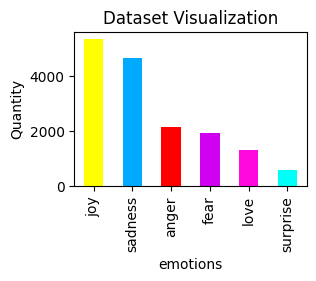

In [10]:
train_data["label_name"].value_counts().plot(kind='bar',figsize=(3, 2),color=['yellow', '#00ABFF', 'red', '#D001F0', '#FF09DF','#00fff7'], xlabel = "emotions",ylabel="Quantity",title="Dataset Visualization")


## Step 5 - Data Preprocessing Functions Before Training

In [11]:
# Tokenizer Function
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(all_list)
word_index1 = tokenizer1.word_index

print("Number of words without Stemming:",len(word_index1))

stemmer = PorterStemmer()
stemmed_words = [stemmer.stem(word) for word in word_index1.keys()]

tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(stemmed_words)
word_index2 = tokenizer2.word_index
print("Number of words with Stemming:",len(word_index2))


Number of words without Stemming: 17096
Number of words with Stemming: 11705


In [12]:
def preprocess_data(data):
    new_data = []
    for index, row in data.iterrows():
        test_split = row['text'].split()
        stemmed_words2 = [stemmer.stem(word) for word in test_split]
        token_list= tokenizer2.texts_to_sequences([stemmed_words2])[0]
        new_data.append([token_list,row['label']]) 
    return new_data

In [13]:
# Represting Tozenized sentences
new_train_data = preprocess_data(train_data)
print(train_data['text'][0])
print(new_train_data[0])    

i didnt feel humiliated
[[3198, 3265, 220, 665], 0]


In [14]:
new_val_data = preprocess_data(val_data)
print(val_data['text'][5])
print(new_val_data[5])    

i start to feel more appreciative of what god has done for me
[[3198, 228, 3200, 220, 3219, 129, 1274, 1284, 1329, 1299, 3305, 3206, 578], 1]


In [15]:
new_test_data = preprocess_data(test_data)
print(test_data['text'][5])
print(new_test_data[5]) 

i cant walk into a shop anywhere where i do not feel uncomfortable
[[3198, 3259, 257, 3249, 3202, 768, 3628, 3271, 3198, 582, 1278, 220, 3365], 4]


In [16]:
# Splitting into train_X and train_y
train_X = [row[0] for row in new_train_data]
train_y = [row[1] for row in new_train_data]
# Print the results
print("train_X:", train_X[0])
print("train_y:", train_y[0])

train_X: [3198, 3265, 220, 665]
train_y: 0


In [17]:
val_X = [row[0] for row in new_val_data]
val_y = [row[1] for row in new_val_data]

print("train_X:", val_X[0])
print("train_y:", val_y[0])

train_X: [3205, 220, 595, 1335, 3199, 3326, 3206, 3227, 3207, 1326, 518, 1283, 1274, 1276, 3380]
train_y: 0


In [18]:
test_X = [row[0] for row in new_test_data]
test_y = [row[1] for row in new_test_data]

print("test_X:", test_X[0])
print("test_y:", test_y[0])

test_X: [3205, 220, 3290, 3441, 3204, 3205, 1278, 3224, 4624, 87, 3230]
test_y: 0


## Step 6 - Finding Longest Sentence in order to make dataset symmetric

In [19]:
length_of_longest_sentence = len(max(train_X, key=len))
print(length_of_longest_sentence)
print(max(train_X, key=len))

66
[3198, 613, 3250, 3588, 3217, 3204, 3198, 927, 3245, 1497, 3245, 1354, 3217, 3245, 1303, 1296, 3200, 2107, 1284, 1276, 3220, 220, 3598, 3213, 220, 1276, 3528, 3217, 7890, 4263, 3221, 5569, 1552, 3243, 3198, 4263, 3221, 1552, 5570, 5570, 3198, 3579, 5569, 3198, 7891, 1276, 3200, 3202, 1293, 3219, 1401, 3948, 3598, 3213, 3223, 239, 3528, 3213, 85, 3267, 579, 1658, 3206, 3201, 239, 1289]


## Step 7 - Adding Padding to the Dataset length equal to length of Longest Sentence

In [20]:
for i in range(len(train_X)):
    for j in range(length_of_longest_sentence-len(train_X[i])):
        train_X[i].append(0)
        
for i in range(len(val_X)):
    for j in range(length_of_longest_sentence-len(val_X[i])):
        val_X[i].append(0)
        
for i in range(len(test_X)):
    for j in range(length_of_longest_sentence-len(test_X[i])):
        test_X[i].append(0)

In [21]:
train_X = np.array(train_X)
train_y = np.array(train_y)

val_X = np.array(val_X)
val_y = np.array(val_y)

test_X = np.array(test_X)
test_y = np.array(test_y)

print(train_X.shape,train_y.shape)
print(val_X.shape,val_y.shape)
print(test_X.shape,test_y.shape)


(16000, 66) (16000,)
(3000, 66) (3000,)
(1000, 66) (1000,)


## Step 8 - Training Using Bidirectional LSTMs

### Architecture Diagram-
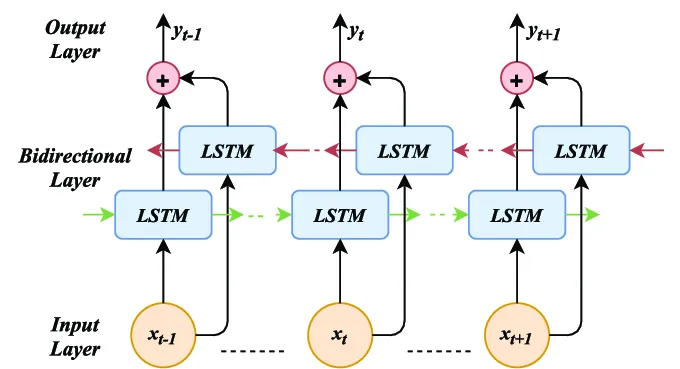!

In [22]:
model = Sequential()
model.add(Embedding(16000, 150, input_length=66))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(16000, activation='softmax'))
adam = Adam(lr=0.001)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
history = model.fit(train_X, train_y, epochs=10, verbose=1,validation_data=(val_X,val_y))
print(model)

Epoch 1/10


I0000 00:00:1719757396.678545      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 [==============================] - 31s 54ms/step - loss: 1.8318 - sparse_categorical_accuracy: 0.3139 - val_loss: 1.5953 - val_sparse_categorical_accuracy: 0.3540
Epoch 2/10
500/500 [==============================] - 8s 15ms/step - loss: 1.5956 - sparse_categorical_accuracy: 0.3254 - val_loss: 1.5885 - val_sparse_categorical_accuracy: 0.3540
Epoch 3/10
500/500 [==============================] - 7s 15ms/step - loss: 1.5937 - sparse_categorical_accuracy: 0.3235 - val_loss: 1.5819 - val_sparse_categorical_accuracy: 0.3540
Epoch 4/10
500/500 [==============================] - 6s 13ms/step - loss: 1.5851 - sparse_categorical_accuracy: 0.3318 - val_loss: 1.5389 - val_sparse_categorical_accuracy: 0.4000
Epoch 5/10
500/500 [==============================] - 7s 13ms/step - loss: 1.2717 - sparse_categorical_accuracy: 0.5291 - val_loss: 1.0110 - val_sparse_categorical_accuracy: 0.6513
Epoch 6/10
500/500 [==============================] - 6s 13ms/step - loss: 0.8036 - sparse_categorical_ac

## Step 9 - Calculating Accuracy

In [23]:
# Training Accuracy
last_accuracy = "{:.3f}".format(history.history['sparse_categorical_accuracy'][-1])
print("Training Accuracy:", last_accuracy)

Training Accuracy: 0.949


In [24]:
# Test Dataset Accuracy
testloss, test_acc = model.evaluate(test_X,test_y)
print('Test accuracy:', test_acc*100)

32/32 [==============================] - 0s 8ms/step - loss: 0.3211 - sparse_categorical_accuracy: 0.8950
Test accuracy: 89.49999809265137


## Step 10 - Plotting Accuracy and Loss Graphs

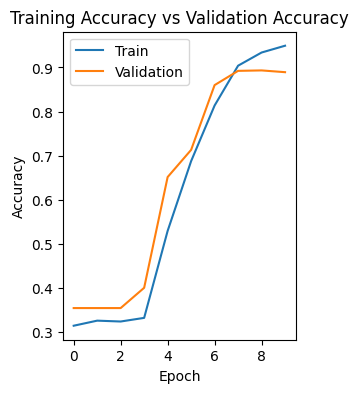

In [25]:
plt.figure(figsize=(3, 4)) 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

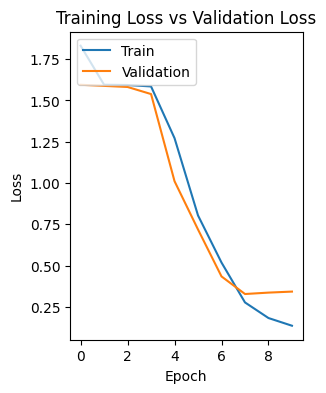

In [26]:
plt.figure(figsize=(3, 4)) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Step 11 - Functions for Additional Testing

In [27]:
def get_text(text):

    tokenizer3 = Tokenizer()
    tokenizer3.fit_on_texts(text)
    word_index3 = tokenizer3.word_index
    
    stemmed_words = [stemmer.stem(word) for word in text.split()]
    tokens_list= tokenizer2.texts_to_sequences([stemmed_words])[0]
    print(tokens_list)

    for i in range(len(tokens_list)):
        for j in range(length_of_longest_sentence-len(tokens_list)):
            tokens_list.append(0)
    return tokens_list


In [28]:
def tester(test):
    test = get_text(test)
    test = np.array(test)
    test = test.reshape(1, len(test))
    
    predictions = model.predict(test)
    predicted_class = np.argmax(predictions)
    
    print()
    print("Predicted Emotion:",labels_dict.get(predicted_class))
    print()

In [29]:
test1 = "I adore my sister too much!"
test2 = "I cry as I notice how horrible this situation has gotten"
test3 = "I am upset with my friend for breaking the case"

tester(test1)
tester(test2)
tester(test3)

[3198, 74, 3203, 1494, 3247]
1/1 [==============================] - 1s 724ms/step

Predicted Emotion: love

[3198, 295, 3212, 3198, 16, 1285, 1379, 580, 642, 1299, 3523]
1/1 [==============================] - 0s 23ms/step

Predicted Emotion: love

[3198, 3209, 675, 3210, 3203, 1317, 3206, 694, 3201, 711]
1/1 [==============================] - 0s 22ms/step

Predicted Emotion: love



In [30]:
new_test_data=preprocess_data(test_data)

test_X = [row[0] for row in new_train_data]
test_y = [row[1] for row in new_train_data]

for i in range(len(test_X)):
    for j in range(length_of_longest_sentence-len(test_X[i])):
        test_X[i].append(0)
        
test_X = np.array(test_X) 
test_y = np.array(test_y)  

test_y_one_hot = to_categorical(test_y, num_classes=16000)

## Step 12 - Plotting Confusion Matrix

500/500 [==============================] - 2s 4ms/step


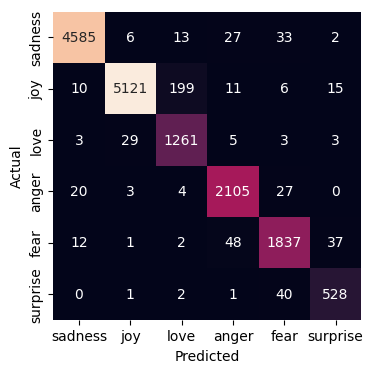

In [31]:
y_true_labels = np.argmax(test_y_one_hot,axis=1)
y_pred = model.predict(test_X)
y_pred_classes = np.argmax(y_pred, axis=1)
labels=['sadness','joy','love','anger','fear','surprise']


cm = confusion_matrix(y_true_labels, y_pred_classes)
df_cm = pd.DataFrame(cm, labels, labels)
plt.figure(figsize=(4,4)) 
ax = sns.heatmap(df_cm, annot=True, annot_kws={'size': 10}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 6) 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
ax.invert_yaxis() 
plt.show()


In [32]:
from tensorflow.keras.models import load_model
model.save('Emotions_Project.h5')
new_model = load_model('Emotions_Project.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
